In [1]:
######################
#import useful modules
######################
%load_ext memory_profiler

import sys

sys.path.append("/home2/datahome/jgula/Python_Modules_p3/")

from Modules import *
from Modules_gula import *

import scipy.stats as st
import functools

from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as colors
########

%matplotlib inline


no basemap module installed


In [2]:
###########################
# Pick a simulation and time

simulname = 'gigatl1_1h_surf'; 

time = 44928 # 2009-03-01
#time = 48600 # 2009-08-01
time = 36648 # 2008-03-21
#time = 40368 # 2008-08-23


####################################
# Pick a grid point and a domain size

laty = 10900
latx = 5150
size = 400

###################################################################################
# Load simulation over the zoomed region

ix1=np.max([0,latx-size]); ix2=latx+size
iy1=np.max([0,laty-size]); iy2=laty+size

%memit simul =  load(simul = simulname + ' [' + format(iy1) + ',' + format(iy2)\
                                       +  ',' + format(ix1) + ',' + format(ix2) +',[1,300,1]] ' + format(time),\
                     output=False);

print(simul.date)


peak memory: 144.22 MiB, increment: 41.58 MiB
Mar 21 - 00:57


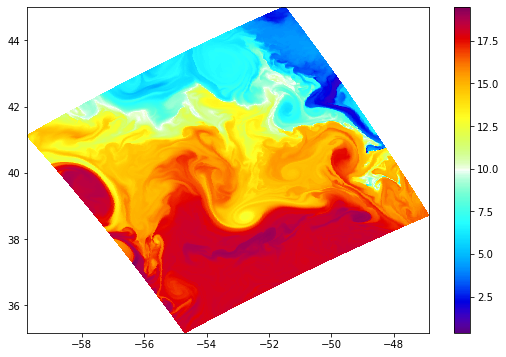

In [3]:
# Plot horizontal SST map of the region
###############################

sst =  var('temp',simul,depths=[0]).data

###############################

my_cmap=plot.ncview_colormap('jaisnc')

###############################

fig = plt.figure(figsize=(9.0,6.0))

###############################

ax1 = plt.subplot(1,1,1);
CS1 = plt.pcolormesh(simul.x.T,simul.y.T,ma.masked_invalid(sst.T),\
                     cmap=my_cmap, rasterized=True);
plt.colorbar()



    

In [4]:
# Compute variables over the domain at different depths
###############################################

depths=[0]

print('vrt')
vrt = tools.nanbnd( (tools.psi2rho(var('vrt',simul,depths=depths).data).T/simul.f.T ).T ,1)
print('strain')
strain = tools.nanbnd(( var('str',simul,depths=depths).data.T / simul.f.T ).T ,1)
print('div')
div = tools.nanbnd(( var('div',simul,depths=depths).data / simul.f.T ).T  ,1)

###############################
print('dxbuoy2')
dxbuoy2 = 2.*np.sqrt(var('dxbuoy2',simul,depths=depths).data)

###############################


vrt
strain
div
dxbuoy2


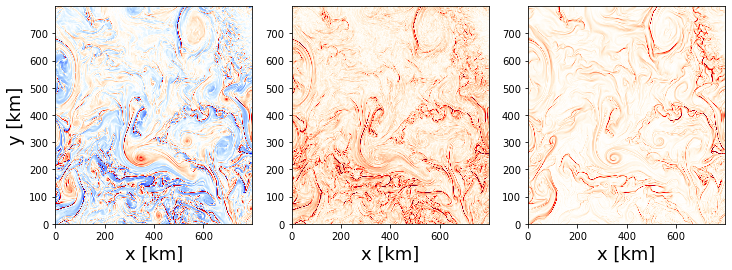

In [5]:
# Plot variables over the domain
###############################################


#############################################
# From lat/lon to km

simul.x = np.cumsum(1/simul.pm,axis=0)/1000.
simul.y = np.cumsum(1/simul.pn,axis=1)/1000.
simul.x -=  simul.x[0,0]
simul.y -=  simul.y[0,0]

#############################################

##################################################

my_cmap=plot.ncview_colormap('blu_red')
levels = np.arange(-1.,1.01,0.01)*2.    
levelsw = np.arange(-1.,1.01,0.01)*1e-6 


###############################


fig = plt.figure(figsize=(12.0,4.0))

###############################

ax1 = plt.subplot(1,3,1);
CS1 = plt.pcolormesh(simul.x.T,simul.y.T,ma.masked_invalid(vrt[:,:].T),vmin=min(levels), vmax=max(levels),cmap=my_cmap,rasterized=True);
plt.ylabel(r'y [km]',fontsize=18); plt.xlabel(r'x [km]',fontsize=18);

###############################
ax1 = plt.subplot(1,3,2);
CS1 = plt.pcolormesh(simul.x.T,simul.y.T,ma.masked_invalid(strain[:,:].T),vmin=min(levels), vmax=max(levels),cmap=my_cmap,rasterized=True);
plt.xlabel(r'x [km]',fontsize=18);

###############################
ax1 = plt.subplot(1,3,3);
CS1 = plt.pcolormesh(simul.x.T,simul.y.T,ma.masked_invalid(dxbuoy2[:,:].T),vmin=min(levelsw), vmax=max(levelsw),cmap=my_cmap,rasterized=True);
plt.xlabel(r'x [km]',fontsize=18);



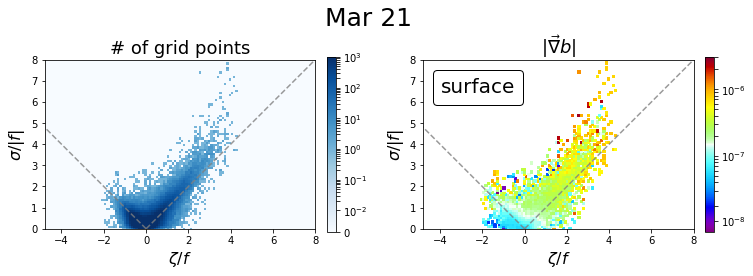

In [7]:

# Functions to plot JPDF
########################

import scipy.stats as st

def jpdf(vrt,strain,w,label,vrtsfc=None,strainsfc=None,varname='w',cond=None,\
         cmap = 'blu_red', levels=np.linspace(-1e-2,1e-2,100)):
    
    
    if cond is None:
        cond = np.isfinite(vrt)
    
    ###################

    my_cmap=plot.ncview_colormap(cmap); 
    
    if varname=='div':
        varlabel = 'Divergence [10$^{-2}$]'
    elif varname=='dxbuoy2':
        #varlabel=r'$\frac{1}{2} \| \vec{\nabla} b \|^2 $'    
        varlabel=r'$ \| \vec{\nabla} b \| $'    
    elif varname=='tendency':
        varlabel = '$T^b_{adv}$' 
    else:
        varlabel = 'Vertical velocity' 
    
    ###################
    
    if vrtsfc is None: vrtsfc=vrt
    if strainsfc is None: strsfc=strain

    xlim_ref = 8; bins_ = np.linspace(-xlim_ref,xlim_ref,150)
    sample_points_identity = np.arange(0,10,0.1)

    ##########
    f,axes = plt.subplots(1,2,figsize=(12,4)) #,facecolor='Gainsboro') #, constrained_layout=True)

    for axe in axes:
        axe.plot(sample_points_identity, sample_points_identity, '--', c = 'gray', alpha = 0.8)
        axe.plot(-sample_points_identity, sample_points_identity, '--', c = 'gray', alpha = 0.8)
        axe.set_xlim((-0.6*xlim_ref,1.*xlim_ref)) ; axe.set_ylim((0,1.*xlim_ref)) ; axe.set_aspect('equal')
        axe.set_xlabel(r'$\zeta/f$',fontsize=16); axe.set_ylabel(r'$\sigma/|f|$',fontsize=16)

        
    ####################
    ## Density of particles
    d_vrt_strain, xedges, yedges,_ = st.binned_statistic_2d(vrt[cond].ravel(),strain[cond].ravel(),\
                                                            values=vrt[cond].ravel(),statistic='count', bins = bins_)
    
    # Plot 2D histogram using pcolormesh
    im = axes[0].pcolormesh(xedges,yedges,ma.masked_invalid(d_vrt_strain.T),\
                            cmap='Blues',norm=colors.SymLogNorm(linthresh=0.01,vmin=0,vmax=1000))
    f.colorbar(im, ax = axes[0],fraction=0.03, pad=0.04)
    axes[0].set_title('# of grid points',fontsize=18)
    
    
    ####################
    ## vertical velocity
    w_vrt_strain, xedges, yedges,_ = st.binned_statistic_2d(vrt[cond].ravel(),strain[cond].ravel(),values=w[cond].ravel(),\
                                                        statistic='mean', bins = bins_)
    #w_vrt_strain[d_vrt_strain<1] = np.nan # Replace values where the JPDF is really low (i.e. ery unlikely points) by nan
    # so that they do not pollute the figure !

    # Plot 2D histogram using pcolormesh
    im = axes[1].pcolormesh(xedges,yedges,ma.masked_invalid(w_vrt_strain.T),cmap=my_cmap,\
                            norm=colors.SymLogNorm(linthresh=levels.max()/100,vmin=levels.min(),vmax=levels.max()))
    f.colorbar(im, ax = axes[1],fraction=0.03, pad=0.04)

        
    axes[1].set_title(varlabel,fontsize=18)
    

    
    # add label
    at = AnchoredText(label,loc=2, prop=dict(size=20), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2"); axes[1].add_artist(at)
    
    plt.subplots_adjust(wspace=0.3)
    
    plt.suptitle(simul.date[:-8], fontsize=25)
    
    
    filename = simulname + '_' + format(time) + '_' +  varname + '_z' + label.replace(" ", "") 
        
    plt.savefig(filename + '.png' ,bbox_inches='tight', transparent='true', dpi=200)

    
###############################


jpdf(vrt[:,:],strain[:,:],dxbuoy2[:,:],'surface',\
         vrtsfc=vrt[:,:],strainsfc=strain[:,:],varname='dxbuoy2', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*3e-6,)

